In [1]:
"""
Topic: Using Isolation Forest(IF) and Extended Isolation Forest (EIF)

Date 10/14/19
Souce:
Extended Isolation Forest (EIF)
- Hariri, S., Kind, M. C., & Brunner, R. J. (2018). Extended Isolation Forest. _arXiv preprint arXiv_:1811.02141.
- https://towardsdatascience.com/outlier-detection-with-extended-isolation-forest-1e248a3fe97b
- https://linuxize.com/post/how-to-install-pip-on-ubuntu-18.04/
- https://github.com/sahandha/eif

Isolation Forest (IF)
- https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e
- https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py

Contour Label
- https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/contourf_demo.html#sphx-glr-gallery-images-contours-and-fields-contourf-demo-py

Data_Set + Score Calculation
- http://odds.cs.stonybrook.edu/
- https://towardsdatascience.com/outlier-detection-with-extended-isolation-forest-1e248a3fe97b

Goals
1. Compare anomaly score map of EIF and IF
2. Compare outlier detection performance of EIF and IF
3. Use USPORF in outlier detection

"""

# Goal 1: Compare anomaly score map of EIF and IF
## importing libaries ---
%matplotlib inline
import matplotlib.pyplot as plt #plot
import numpy as np #basic calculation
from scipy.stats import multivariate_normal
import random as rn
import eif as iso #download Isolation Forest
import seaborn as sb
sb.set_style(style="whitegrid")
sb.set_color_codes()
import scipy.ndimage 
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed #create the same random
import pandas as pd 

from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from rerf.urerf import UnsupervisedRandomForest


## Utility Function
#>>> Creating the radial plots below. 
#>>> We use these two functions to find the depth (not anomaly score) a given data point reaches in an Isolation Forest tree.
def getDepth(x, root, d):
    n = root.n
    p = root.p
    if root.ntype == 'exNode':
        return d
    else:
        if (x-p).dot(n) < 0:
            return getDepth(x,root.left,d+1)
        else:
            return getDepth(x,root.right,d+1)
        
def getVals(forest,x, sorted=True):
    theta = np.linspace(0,2*np.pi, forest.ntrees)
    r = []
    for t in forest.Trees:
        r.append(getDepth(x,t.root,1))
    if sorted:
        r = np.sort(np.array(r))
    return r, theta

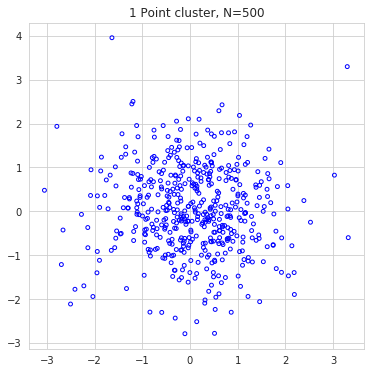

In [2]:
# EX1 Single Blob Example

mean = [0, 0]
cov = [[1,0], [0, 1]]  # covariance matrix: R^(2x2)
Nobjs = 500 # sample population
np.random.seed(1) # for a repeatable result
x, y = np.random.multivariate_normal(mean, cov, Nobjs).T 
x[0]=3.3  # adjust manual outlier
y[0]=3.3
X=np.array([x,y]).T # transpose

fig=plt.figure(figsize=(6,6))
fig.add_subplot(111)
plt.scatter(x,y,s=15,c='None',edgecolor='blue') 
plt.title('1 Point cluster, N=500')
plt.show()




In [3]:
### Train Forest(s)
#>>> F0 is the standard Isolation Forest
#>>> F1 is the Extended Isolation Forest with extension 1
F0  = iso.iForest(X, ntrees=100, sample_size=256, ExtensionLevel=0)
F1  = iso.iForest(X, ntrees=100, sample_size=256, ExtensionLevel=1)

### Anomaly (Outlier) Score
S0 = F0.compute_paths(X_in=X)
S1 = F1.compute_paths(X_in=X)
ss0=np.argsort(S0) # index element from low to high
ss1=np.argsort(S1)
#>>> x = np.array([3, 1, 2])
#>>> np.argsort(x)
#: array([1, 2, 0])

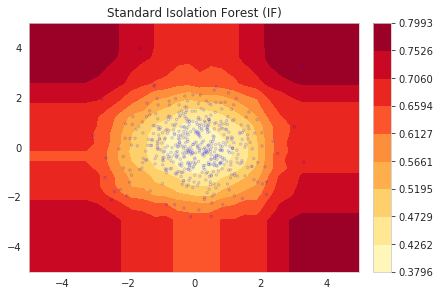

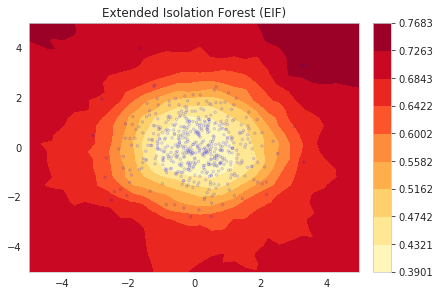

In [4]:
## (Outlier) Socre map s(x,n)
#>>> create a contour plot of score map
import numpy as np
xx, yy = np.meshgrid(np.linspace(-5., 5., 30), np.linspace(-5., 5, 30))

S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()]) # flatten: make 2D line space -> 1D
S0 = S0.reshape(xx.shape)

S1 = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1 = S1.reshape(xx.shape)

fig1, ax1= plt.subplots(constrained_layout=True)
#ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0),np.max(S0),10)
CS1 = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.YlOrRd)
cbar = fig1.colorbar(CS1)#
#cbar.ax1.set_ylabel('anomaly score')

plt.scatter(x,y,s=5,c='None',edgecolor='blue', alpha = 0.2)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title('Standard Isolation Forest (IF)')

fig2, ax2= plt.subplots(constrained_layout=True)
#ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1),np.max(S1),10)
CS2 = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.YlOrRd)
cbar = fig2.colorbar(CS2)#
#cbar.ax2.set_ylabel('anomaly score')

plt.scatter(x,y,s=5,c='None',edgecolor='blue', alpha = 0.2)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title('Extended Isolation Forest (EIF)')


plt.show()

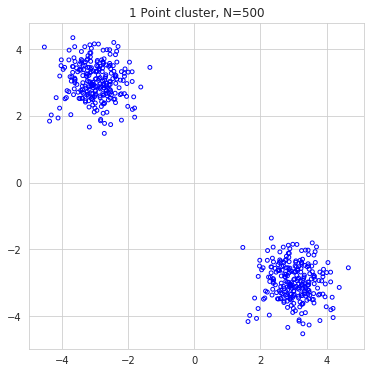

In [5]:
# EX2 two point cluster Example

## data
mean1 = [3, -3]
cov1= [[0.3,0], [0, 0.3]]  # covariance matrix: R^(2x2)
Nobjs = 250 
np.random.seed(1) 
x1, y1 = np.random.multivariate_normal(mean1, cov1, Nobjs).T 

mean2 = [-3, 3]
cov2= [[0.3,0], [0, 0.3]]
np.random.seed(1) # for a repeatable result
x2, y2 = np.random.multivariate_normal(mean2, cov2, Nobjs).T 

x=np.append(x1,x2)
y=np.append(y1,y2)

X=np.array([x,y]).T # transpose

fig=plt.figure(figsize=(6,6))
fig.add_subplot(111)
plt.scatter(x,y,s=15,c='None',edgecolor='blue') 
plt.title('1 Point cluster, N=500')
plt.show()


In [6]:
### Train Forest(s)
F0  = iso.iForest(X, ntrees=100, sample_size=256, ExtensionLevel=0) # IF
F1  = iso.iForest(X, ntrees=100, sample_size=256, ExtensionLevel=1) # EIF

### Anomaly (Outlier) Score
S0 = F0.compute_paths(X_in=X)
S1 = F1.compute_paths(X_in=X)
ss0=np.argsort(S0) # index element from low to high
ss1=np.argsort(S1)
#>>> x = np.array([3, 1, 2])
#>>> np.argsort(x)
#: array([1, 2, 0])

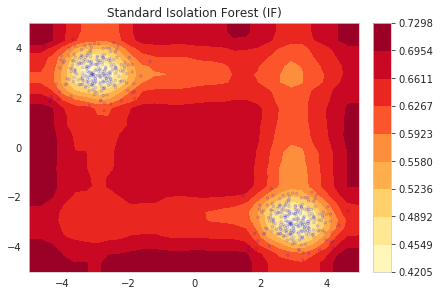

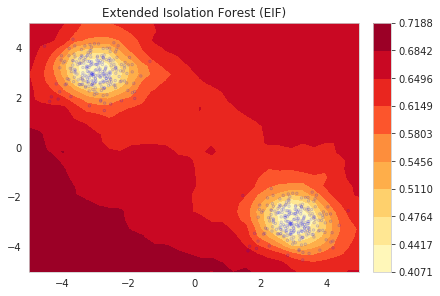

In [7]:
## (Outlier) Socre map s(x,n)
#>>> create a contour plot of score map
import numpy as np
xx, yy = np.meshgrid(np.linspace(-5., 5., 30), np.linspace(-5., 5, 30))

S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()]) # flatten: make 2D line space -> 1D
S0 = S0.reshape(xx.shape)

S1 = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1 = S1.reshape(xx.shape)

fig1, ax1= plt.subplots(constrained_layout=True)
#ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0),np.max(S0),10)
CS1 = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.YlOrRd)
cbar = fig1.colorbar(CS1)#
#cbar.ax1.set_ylabel('anomaly score')

plt.scatter(x,y,s=5,c='None',edgecolor='blue', alpha = 0.2)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title('Standard Isolation Forest (IF)')

fig2, ax2= plt.subplots(constrained_layout=True)
#ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1),np.max(S1),10)
CS2 = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.YlOrRd)
cbar = fig2.colorbar(CS2)#
#cbar.ax2.set_ylabel('anomaly score')

plt.scatter(x,y,s=5,c='None',edgecolor='blue', alpha = 0.2)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title('Extended Isolation Forest (EIF)')


plt.show()

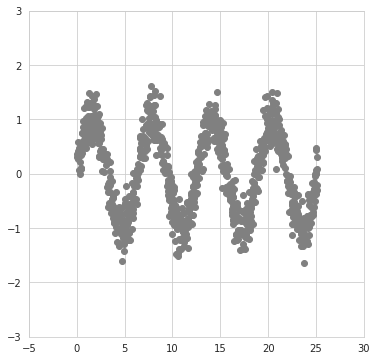

In [8]:
N = 1000
x = np.random.rand(N)*8*np.pi
y = np.sin(x) + np.random.randn(N)/4.
X=np.array([x,y]).T

fig=plt.figure(figsize=(6,6))
fig.add_subplot(111)
plt.plot(X[:,0],X[:,1],'o', color=[0.5,0.5,0.5])

plt.xlim([-5,30])
plt.ylim([-3.,3.])

plt.show()

In [9]:
### Train Forest(s)
F0  = iso.iForest(X, ntrees=100, sample_size=256, ExtensionLevel=0) # IF
F1  = iso.iForest(X, ntrees=100, sample_size=256, ExtensionLevel=1) # EIF

### Anomaly (Outlier) Score
S0 = F0.compute_paths(X_in=X)
S1 = F1.compute_paths(X_in=X)
ss0=np.argsort(S0) # index element from low to high
ss1=np.argsort(S1)
#>>> x = np.array([3, 1, 2])
#>>> np.argsort(x)
#: array([1, 2, 0])

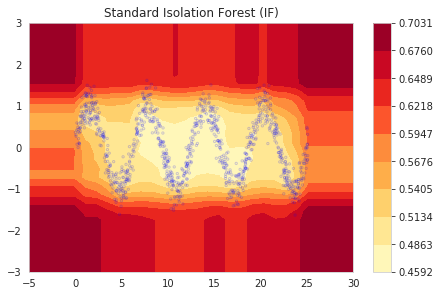

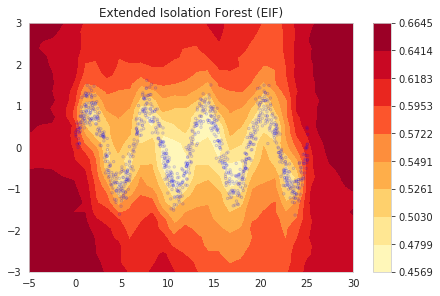

In [10]:
## (Outlier) Socre map s(x,n)
#>>> create a contour plot of score map
import numpy as np
xx, yy = np.meshgrid(np.linspace(-5., 30, 30), np.linspace(-3., 3, 30))

S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()]) # flatten: make 2D line space -> 1D
S0 = S0.reshape(xx.shape)

S1 = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1 = S1.reshape(xx.shape)

fig1, ax1= plt.subplots(constrained_layout=True)
#ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0),np.max(S0),10)
CS1 = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.YlOrRd)
cbar = fig1.colorbar(CS1)#
#cbar.ax1.set_ylabel('anomaly score')

plt.scatter(x,y,s=5,c='None',edgecolor='blue', alpha = 0.2)
plt.xlim(-5, 30)
plt.ylim(-3, 3)
plt.title('Standard Isolation Forest (IF)')

fig2, ax2= plt.subplots(constrained_layout=True)
#ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1),np.max(S1),10)
CS2 = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.YlOrRd)
cbar = fig2.colorbar(CS2)#
#cbar.ax2.set_ylabel('anomaly score')

plt.scatter(x,y,s=5,c='None',edgecolor='blue', alpha = 0.2)
plt.xlim(-5, 30)
plt.ylim(-3, 3)
plt.title('Extended Isolation Forest (EIF)')


plt.show()

In [11]:
# Goal2: Compare outlier detection performance of EIF and IF

In [25]:
## Import Data 1: Vertebral
### source: http://odds.cs.stonybrook.edu/
### sample = 240, dimension = 6, outlier = 30(12.15%)
### y = 'AB'= inliner, y='NO' = outlier

import scipy.io as sio

mat = scipy.io.loadmat('vertebral.mat')
X = pd.DataFrame(mat['X'])              # pandas.core.frame.DataFrame
y = pd.Series([x[0] for x in mat['y']]) # pandas.core.series.Series

# define % of anomalies
anomalies_ratio = 0.125 # we need to find the 'AB (majority)'

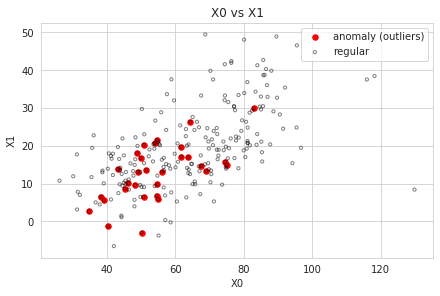

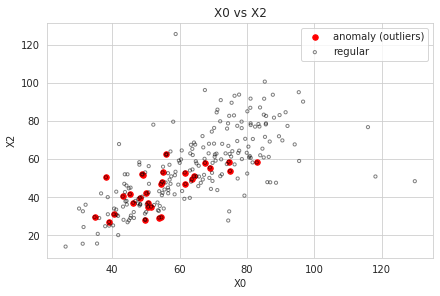

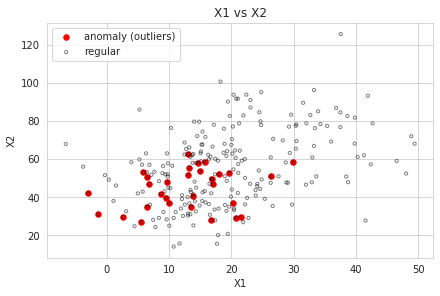

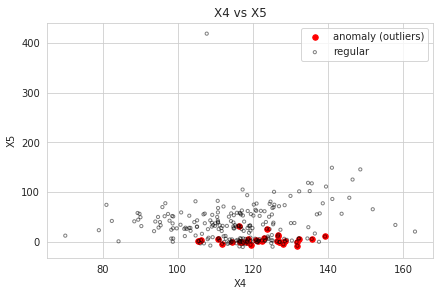

In [26]:
## Visualized data
fig1, ax1= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,0][y.values>0],X.values[:,1][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,0],X.values[:,1],s=10,c='None',edgecolor='black', alpha = 0.5)
plt.title('X0 vs X1')
plt.xlabel('X0')
plt.ylabel('X1')
plt.legend(['anomaly (outliers)','regular'])

fig2, ax2= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,0][y.values>0],X.values[:,2][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,0],X.values[:,2],s=10,c='None',edgecolor='black', alpha = 0.5)
plt.title('X0 vs X2')
plt.xlabel('X0')
plt.ylabel('X2')
plt.legend(['anomaly (outliers)','regular'])


fig3, ax3= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,1][y.values>0],X.values[:,2][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,1],X.values[:,2],s=10,c='None',edgecolor='black', alpha = 0.5)
plt.title('X1 vs X2')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(['anomaly (outliers)','regular'])


fig4, ax4= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,4][y.values>0],X.values[:,5][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,4],X.values[:,5],s=10,c='None',edgecolor='black', alpha = 0.5)
plt.title('X4 vs X5')
plt.xlabel('X4')
plt.ylabel('X5')
plt.legend(['anomaly (outliers)','regular'])


plt.show()


In [27]:
# prediction
F0 = iso.iForest(X.values, ntrees = 100, sample_size = 100, ExtensionLevel = 0) # numpy.ndarray
F1 = iso.iForest(X.values, ntrees = 100, sample_size = 100, ExtensionLevel = 1)

# calculate anomaly scores
S0 = F0.compute_paths(X_in = X.values)
S1 = F1.compute_paths(X_in = X.values)
# sort the scores
ss0 = np.argsort(S0)
ss1 = np.argsort(S1)

# retrieve indices of anomalous observations
indices0 = ss0[-int(np.ceil(anomalies_ratio * X.shape[0])):] # choose anomolies_ratio =1- .125
indices1 = ss0[-int(np.ceil(anomalies_ratio * X.shape[0])):]

# create predictions 
y_pred0 = np.zeros_like(y)  # '0' array
y_pred0[indices0] = 1       # set some to '1'
y_pred1 = np.zeros_like(y)
y_pred1[indices1] = 1


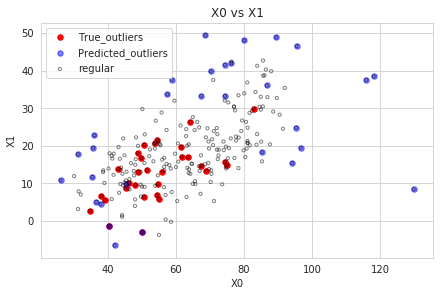

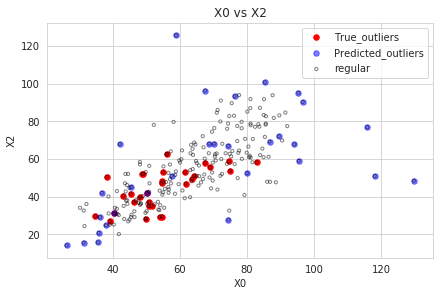

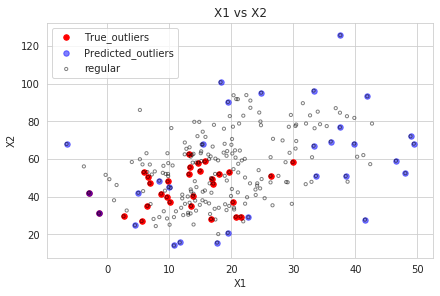

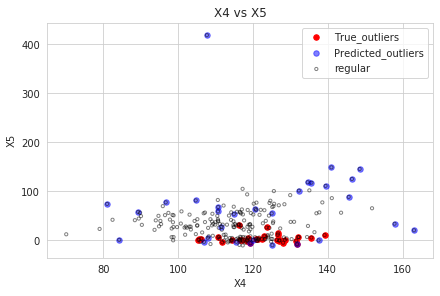

In [28]:
## Visualized data + prediction
fig1, ax1= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,0][y.values>0],X.values[:,1][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,0][y_pred0>0],X.values[:,1][y_pred0>0],s=30,c='blue',edgecolor='blue', alpha = 0.5)
plt.scatter(X.values[:,0],X.values[:,1],s=10,c='None',edgecolor='black', alpha = 0.5)
plt.title('X0 vs X1')
plt.xlabel('X0')
plt.ylabel('X1')
plt.legend(['True_outliers','Predicted_outliers','regular'])

fig2, ax2= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,0][y.values>0],X.values[:,2][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,0][y_pred0>0],X.values[:,2][y_pred0>0],s=30,c='blue',edgecolor='blue', alpha = 0.5)
plt.scatter(X.values[:,0],X.values[:,2],s=10,c='None',edgecolor='black', alpha = 0.5)
plt.title('X0 vs X2')
plt.xlabel('X0')
plt.ylabel('X2')
plt.legend(['True_outliers','Predicted_outliers','regular'])


fig3, ax3= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,1][y.values>0],X.values[:,2][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,1][y_pred0>0],X.values[:,2][y_pred0>0],s=30,c='blue',edgecolor='blue', alpha = 0.5)
plt.scatter(X.values[:,1],X.values[:,2],s=10,c='None',edgecolor='black', alpha = 0.5)
plt.title('X1 vs X2')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(['True_outliers','Predicted_outliers','regular'])


fig4, ax4= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,4][y.values>0],X.values[:,5][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,4][y_pred0>0],X.values[:,5][y_pred0>0],s=30,c='blue',edgecolor='blue', alpha = 0.5)
plt.scatter(X.values[:,4],X.values[:,5],s=10,c='None',edgecolor='black', alpha = 0.5)
plt.title('X4 vs X5')
plt.xlabel('X4')
plt.ylabel('X5')
plt.legend(['True_outliers','Predicted_outliers','regular'])


plt.show()

UnsupervisedRandomForest(feature_combinations='auto', max_depth=None,
                         max_features='auto', min_samples_split='auto',
                         n_estimators=100, n_jobs=None,
                         projection_matrix='RerF', random_state=0)
[[1.   0.   0.13 ... 0.01 0.   0.01]
 [0.   1.   0.   ... 0.01 0.04 0.  ]
 [0.09 0.   1.   ... 0.03 0.   0.04]
 ...
 [0.   0.   0.01 ... 1.   0.1  0.06]
 [0.   0.04 0.   ... 0.05 1.   0.  ]
 [0.   0.   0.04 ... 0.04 0.01 1.  ]]


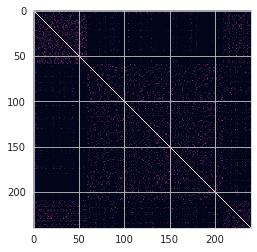

In [30]:
# Goal 3 Mixing with USPORF
clf = UnsupervisedRandomForest(projection_matrix="RerF", random_state=0)
print(clf)
clf.fit(X)
sim_mat = clf.transform()
print(sim_mat)
plt.imshow(sim_mat)

In [31]:
cluster = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
predict_labels = cluster.fit_predict(sim_mat)
score = adjusted_rand_score(y, predict_labels)

print("labels\n", y.values)
print("predict\n", predict_labels)


print("ARI USPORF:", score)
#---
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# % exact value -> not a good measurement because we only have lots of 0's and a few 1's 
print("ARI IF: ",  adjusted_rand_score(y, y_pred0))
print("ARI EIF: ",  adjusted_rand_score(y, y_pred1))

CorrectOut= np.multiply(y,y_pred0).values
print("sum true outlier", sum(y))
print("correct outlier" , sum(CorrectOut)/sum(y))

labels
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
predict
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 2 1 1 2 1 2 2 2 1 1 0
 1 1 1 2 2 0 1 2 1 1 1 0 0 0 0 0 1 2 1 0 1 1 1 1 1 0 1 2 2 0 1 0 2 1 2 2 2
 1 0 2 1 1 2 1 0 0 0 1 1 2 2 0 2 1 1 2 0 2 2 1 0 1 1 1 1 1 2 1 1 0 2 1 1 2
 2 2 1 0 2 0 0 2 1 0 2 2 1 2 1 1 0 1 2 2 1 0 2 1 0 0 0 2 2 1 1 1 0 2 1 1 1
 1 1 2 1 1 0 1 1 1 2 1 2 1 2 2 0 1 1 2 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 2 0 0 2 0 0 0 0 0 0 0 2 0 2 0 0 0 2]
ARI USP

In [34]:
## Import Data 2: Vertebral
### source: http://odds.cs.stonybrook.edu/
### sample = 240, dimension = 6, outlier = 30(12.15%)
### y = 'AB'= inliner, y='NO' = outlier

import scipy.io as sio

mat = scipy.io.loadmat('vertebral.mat')
X = pd.DataFrame(mat['X'])              # pandas.core.frame.DataFrame
y = pd.Series([x[0] for x in mat['y']]) # pandas.core.series.Series

# define % of anomalies
anomalies_ratio = 1-0.125 # we need to find the 'AB (majority)'

In [36]:
# prediction
F0 = iso.iForest(X.values, ntrees = 100, sample_size = 100, ExtensionLevel = 0) # numpy.ndarray
F1 = iso.iForest(X.values, ntrees = 100, sample_size = 100, ExtensionLevel = 1)

# calculate anomaly scores
S0 = F0.compute_paths(X_in = X.values)
S1 = F1.compute_paths(X_in = X.values)
# sort the scores
ss0 = np.argsort(S0)
ss1 = np.argsort(S1)

# retrieve indices of anomalous observations
indices0 = ss0[-int(np.ceil(anomalies_ratio * X.shape[0])):] # choose anomolies_ratio =1- .125
indices1 = ss0[-int(np.ceil(anomalies_ratio * X.shape[0])):]

# create predictions 
y_pred0 = np.zeros_like(y)
y_pred0[indices0] = 1
y_pred1 = np.zeros_like(y)
y_pred1[indices1] = 1


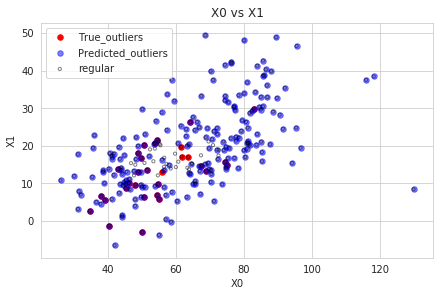

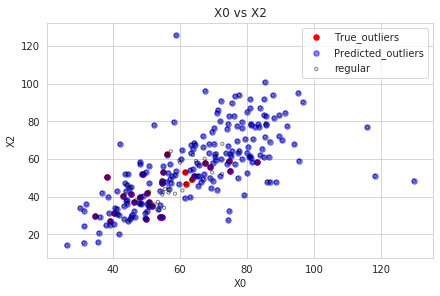

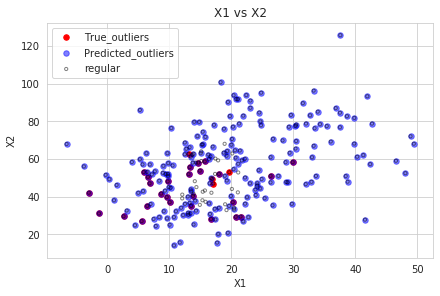

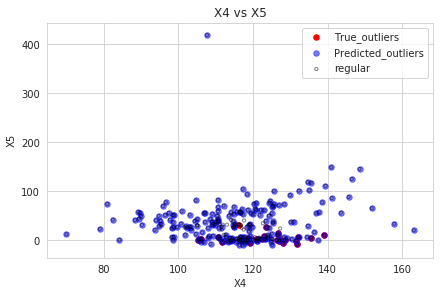

In [37]:
## Visualized data + prediction
fig1, ax1= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,0][y.values>0],X.values[:,1][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,0][y_pred0>0],X.values[:,1][y_pred0>0],s=30,c='blue',edgecolor='blue', alpha = 0.5)
plt.scatter(X.values[:,0],X.values[:,1],s=10,c='None',edgecolor='black', alpha = 0.5)
plt.title('X0 vs X1')
plt.xlabel('X0')
plt.ylabel('X1')
plt.legend(['True_outliers','Predicted_outliers','regular'])

fig2, ax2= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,0][y.values>0],X.values[:,2][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,0][y_pred0>0],X.values[:,2][y_pred0>0],s=30,c='blue',edgecolor='blue', alpha = 0.5)
plt.scatter(X.values[:,0],X.values[:,2],s=10,c='None',edgecolor='black', alpha = 0.5)
plt.title('X0 vs X2')
plt.xlabel('X0')
plt.ylabel('X2')
plt.legend(['True_outliers','Predicted_outliers','regular'])


fig3, ax3= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,1][y.values>0],X.values[:,2][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,1][y_pred0>0],X.values[:,2][y_pred0>0],s=30,c='blue',edgecolor='blue', alpha = 0.5)
plt.scatter(X.values[:,1],X.values[:,2],s=10,c='None',edgecolor='black', alpha = 0.5)
plt.title('X1 vs X2')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(['True_outliers','Predicted_outliers','regular'])


fig4, ax4= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,4][y.values>0],X.values[:,5][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,4][y_pred0>0],X.values[:,5][y_pred0>0],s=30,c='blue',edgecolor='blue', alpha = 0.5)
plt.scatter(X.values[:,4],X.values[:,5],s=10,c='None',edgecolor='black', alpha = 0.5)
plt.title('X4 vs X5')
plt.xlabel('X4')
plt.ylabel('X5')
plt.legend(['True_outliers','Predicted_outliers','regular'])


plt.show()

In [18]:
## Import Data Ver3: Wine
### source: http://odds.cs.stonybrook.edu/
### sample = 129, dimension = 13, outlier = 10(7.7%)
### y = {2,3} = inliner, y={1} = outlier

import scipy.io as sio

mat = scipy.io.loadmat('wine.mat')
X = pd.DataFrame(mat['X'])              # pandas.core.frame.DataFrame
y = pd.Series([x[0] for x in mat['y']]) # pandas.core.series.Series

# define % of anomalies
anomalies_ratio = 0.077

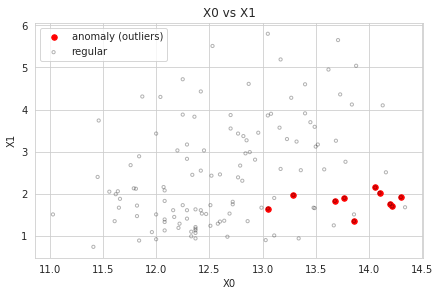

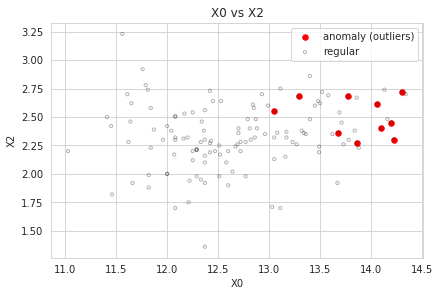

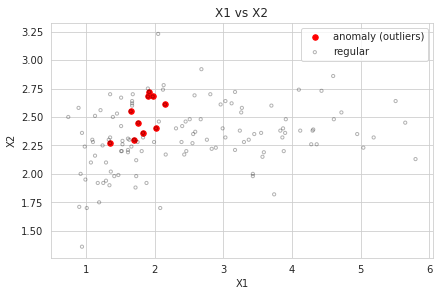

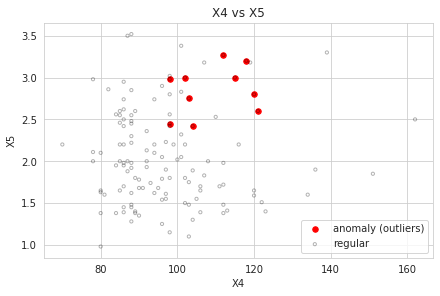

In [19]:
## Visualized data
fig1, ax1= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,0][y.values>0],X.values[:,1][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,0],X.values[:,1],s=10,c='None',edgecolor='black', alpha = 0.3)
plt.title('X0 vs X1')
plt.xlabel('X0')
plt.ylabel('X1')
plt.legend(['anomaly (outliers)','regular'])

fig2, ax2= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,0][y.values>0],X.values[:,2][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,0],X.values[:,2],s=10,c='None',edgecolor='black', alpha = 0.3)
plt.title('X0 vs X2')
plt.xlabel('X0')
plt.ylabel('X2')
plt.legend(['anomaly (outliers)','regular'])


fig3, ax3= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,1][y.values>0],X.values[:,2][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,1],X.values[:,2],s=10,c='None',edgecolor='black', alpha = 0.3)
plt.title('X1 vs X2')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(['anomaly (outliers)','regular'])


fig4, ax4= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,4][y.values>0],X.values[:,5][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,4],X.values[:,5],s=10,c='None',edgecolor='black', alpha = 0.3)
plt.title('X4 vs X5')
plt.xlabel('X4')
plt.ylabel('X5')
plt.legend(['anomaly (outliers)','regular'])


plt.show()


In [20]:
# prediction
F0 = iso.iForest(X.values, ntrees = 100, sample_size = 50, ExtensionLevel = 0) # numpy.ndarray
F1 = iso.iForest(X.values, ntrees = 100, sample_size = 50, ExtensionLevel = 1)

# calculate anomaly scores
S0 = F0.compute_paths(X_in = X.values)
S1 = F1.compute_paths(X_in = X.values)
# sort the scores
ss0 = np.argsort(S0)
ss1 = np.argsort(S1)

# retrieve indices of anomalous observations
indices0 = ss0[-int(np.ceil(anomalies_ratio * X.shape[0])):] # choose anomolies_ratio = 12.5%
indices1 = ss0[-int(np.ceil(anomalies_ratio * X.shape[0])):]

# create predictions 
y_pred0 = np.zeros_like(y)
y_pred0[indices0] = 1
y_pred1 = np.zeros_like(y)
y_pred1[indices1] = 1


# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# % exact value -> not a good measurement because we only have lots of 0's and a few 1's 
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# % exact value -> not a good measurement because we only have lots of 0's and a few 1's 
print("ARI IF: ",  adjusted_rand_score(y, y_pred0))
print("ARI EIF: ",  adjusted_rand_score(y, y_pred1))

CorrectOut= np.multiply(y,y_pred0).values
print("sum true outlier", sum(y))
print("correct outlier" , sum(CorrectOut)/sum(y))

ARI IF:  0.2096035697041343
ARI EIF:  0.2096035697041343
sum true outlier 10
correct outlier 0.3


In [21]:
print("true values\n ",y.values)
print("IF prediction\n ",y_pred0)
print("EIF prediction\n ",y_pred1)

true values
  [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
IF prediction
  [0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
EIF prediction
  [0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


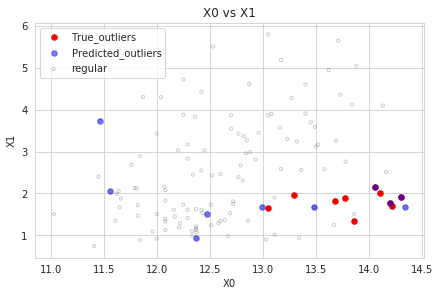

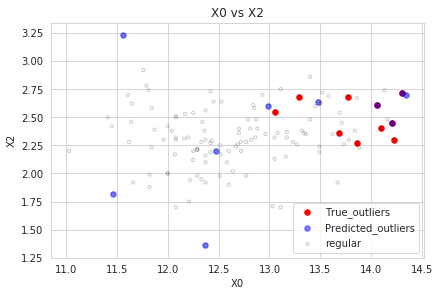

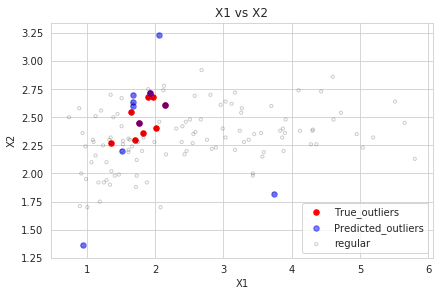

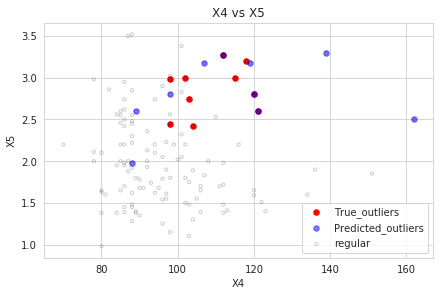

In [22]:
## Visualized data + prediction
fig1, ax1= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,0][y.values>0],X.values[:,1][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,0][y_pred0>0],X.values[:,1][y_pred0>0],s=30,c='blue',edgecolor='blue', alpha = 0.5)
plt.scatter(X.values[:,0],X.values[:,1],s=10,c='None',edgecolor='black', alpha = 0.2)
plt.title('X0 vs X1')
plt.xlabel('X0')
plt.ylabel('X1')
plt.legend(['True_outliers','Predicted_outliers','regular'])

fig2, ax2= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,0][y.values>0],X.values[:,2][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,0][y_pred0>0],X.values[:,2][y_pred0>0],s=30,c='blue',edgecolor='blue', alpha = 0.5)
plt.scatter(X.values[:,0],X.values[:,2],s=10,c='None',edgecolor='black', alpha = 0.2)
plt.title('X0 vs X2')
plt.xlabel('X0')
plt.ylabel('X2')
plt.legend(['True_outliers','Predicted_outliers','regular'])


fig3, ax3= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,1][y.values>0],X.values[:,2][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,1][y_pred0>0],X.values[:,2][y_pred0>0],s=30,c='blue',edgecolor='blue', alpha = 0.5)
plt.scatter(X.values[:,1],X.values[:,2],s=10,c='None',edgecolor='black', alpha = 0.2)
plt.title('X1 vs X2')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(['True_outliers','Predicted_outliers','regular'])


fig4, ax4= plt.subplots(constrained_layout=True)
plt.scatter(X.values[:,4][y.values>0],X.values[:,5][y.values>0],s=30,c='red',edgecolor='red', alpha = 1)
plt.scatter(X.values[:,4][y_pred0>0],X.values[:,5][y_pred0>0],s=30,c='blue',edgecolor='blue', alpha = 0.5)
plt.scatter(X.values[:,4],X.values[:,5],s=10,c='None',edgecolor='black', alpha = 0.2)
plt.title('X4 vs X5')
plt.xlabel('X4')
plt.ylabel('X5')
plt.legend(['True_outliers','Predicted_outliers','regular'])


plt.show()

UnsupervisedRandomForest(feature_combinations='auto', max_depth=None,
                         max_features='auto', min_samples_split='auto',
                         n_estimators=100, n_jobs=None,
                         projection_matrix='RerF', random_state=0)
[[1.   0.38 0.04 ... 0.   0.   0.01]
 [0.33 1.   0.07 ... 0.   0.   0.  ]
 [0.13 0.16 1.   ... 0.   0.01 0.  ]
 ...
 [0.   0.   0.   ... 1.   0.17 0.09]
 [0.   0.   0.   ... 0.25 1.   0.06]
 [0.   0.   0.01 ... 0.08 0.06 1.  ]]


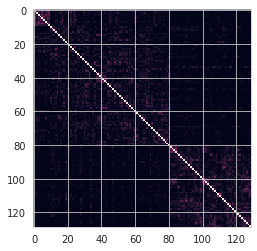

In [23]:
# Goal 3 Mixing with USPORF
clf = UnsupervisedRandomForest(projection_matrix="RerF", random_state=0)
print(clf)
clf.fit(X)
sim_mat = clf.transform()
print(sim_mat)
plt.imshow(sim_mat)

In [24]:
cluster = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
predict_labels = cluster.fit_predict(sim_mat)
score = adjusted_rand_score(y, predict_labels)

print("labels\n", y.values)
print("predict\n", predict_labels)

print("ARI USPORF:", score)
#---
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# % exact value -> not a good measurement because we only have lots of 0's and a few 1's 
print("ARI IF: ",  adjusted_rand_score(y, y_pred0))
print("ARI EIF: ",  adjusted_rand_score(y, y_pred1))

CorrectOut= np.multiply(y,y_pred0).values
print("sum true outlier", sum(y))
print("correct outlier" , sum(CorrectOut)/sum(y))

labels
 [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predict
 [2 2 2 2 2 2 2 2 2 2 0 1 1 0 2 0 0 2 0 1 0 0 2 0 2 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Adjusted Rand Score: 0.18161546261165631


In [43]:
np.array([0,1])*-1+1

array([1, 0])